How did I get the result `precision: 0.944` and `precision:0.974` without `stratify`?  
  
If you are interested in learning only transformations on features and want to compare with your result, then the operations were as follows:

+ using `LabelEncoder()` converted `Gender`, `EverBenched`  
+ using `pd.get_dummies` converted `Education`, `City`, `PaymentTier`  
+ from 2021 subtracted the `JoiningYear` value, updated the attribute.  
  
Then I divided it into `train` and `test`, using `stratify=y` so that the proportions of 1 and 0 in the target variable were the same, both in `train` and in `test`.

Then I scaled the variables of `JoiningYear`, `Age` and `ExperienceInCurrentDomain`.

Trained on `RandomForestClassifier`, `ExtraTreesClassifier` and `GradientBoostingClassifier`.

Unfortunately, I have high `precision` and low `recall`. If you have a `recall` greater than 0.8, then please leave a link to your laptop in the comments - it will be interesting for me to see.

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use("Solarize_Light2")
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/employee-future-prediction/Employee.csv


# Data overview

In [3]:
data = pd.read_csv('/kaggle/input/employee-future-prediction/Employee.csv')

In [4]:
data

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
...,...,...,...,...,...,...,...,...,...
4648,Bachelors,2013,Bangalore,3,26,Female,No,4,0
4649,Masters,2013,Pune,2,37,Male,No,2,1
4650,Masters,2018,New Delhi,3,27,Male,No,5,1
4651,Bachelors,2012,Bangalore,3,30,Male,Yes,2,0


In [5]:
data.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

In [6]:
data.nunique()

Education                     3
JoiningYear                   7
City                          3
PaymentTier                   3
Age                          20
Gender                        2
EverBenched                   2
ExperienceInCurrentDomain     8
LeaveOrNot                    2
dtype: int64

No missing values

# EDA

Let's look at the number of unique values in each of the variables, let's group by `LeaveOrNot`

In [7]:
data.columns

Index(['Education', 'JoiningYear', 'City', 'PaymentTier', 'Age', 'Gender',
       'EverBenched', 'ExperienceInCurrentDomain', 'LeaveOrNot'],
      dtype='object')

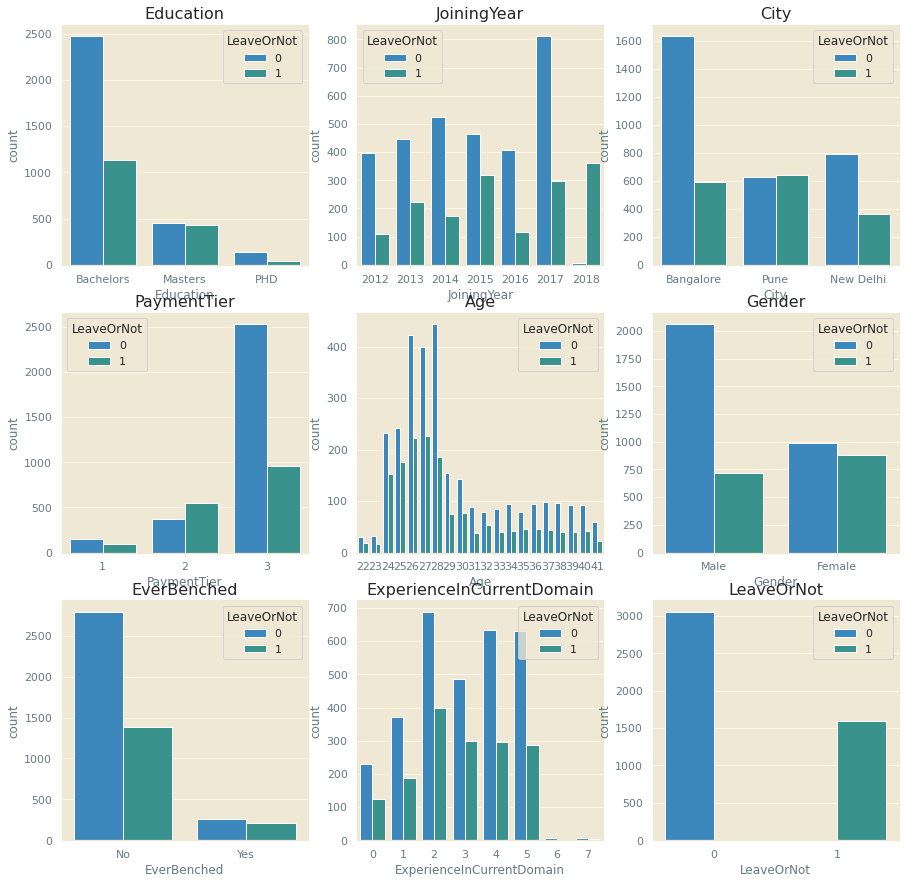

In [8]:
x_col = data.columns
num=0
plt.figure(figsize=(15, 15))
for i in x_col:
    
    num += 1
    plt.subplot(3, 3, num)
    sns.countplot(data=data, x=i, hue='LeaveOrNot').set_title(i)
    

plt.show()

Values of 1 are less than 0, then let's pay attention to the histograms where they are the same height or feature 1 is higher than feature 0:  
  
+ `Education` == Masters
+ `JoiningYear` == 2018
+ `City` == Pune
+ `PaymentTier` == 2
+ `Gender` == Female

Maybe these values in the signs will play a role in our learning

**Let's do the same, but only take the average value for all categories.**

##  Features preprocessing

Convert categorical variables into single columns. We cannot simply number such signs as `Education`, even though `Bachelors`, `Masters`, `PHD` correspond well to 1, 2 and 3. But the average 2 is `Masters * 2` or `Bachelors + PHD`, and this is not the same thing.

In [9]:
data.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [10]:
col_bi = ['Gender', 'EverBenched']
labelencoder = LabelEncoder()
for i in col_bi:
    data[i] = labelencoder.fit_transform(data[i])

In [11]:
data = pd.get_dummies(data, columns=['Education', 'City', 'PaymentTier'])

In [12]:
data.JoiningYear = 2021 - data.JoiningYear

I split the `PaymentTier` variable into 3 single columns, since it is a categorical variable, although there is a dependence on gradation. But we do not know for sure whether the difference between category `1` and `2` in the amount of the actual salary is 2 times or not.

I have brought the variable `JoiningYear` to the current value by subtracting from 2021.

## Обзор признака LeaveOrNot

In [13]:
data.groupby('LeaveOrNot').agg('mean').T

LeaveOrNot,0,1
JoiningYear,6.182116,5.469375
Age,29.571896,29.052500
Gender,0.675401,0.447500
EverBenched,0.085490,0.135625
ExperienceInCurrentDomain,2.940059,2.840000
Education_Bachelors,0.809695,0.705625
Education_Masters,0.146413,0.266250
Education_PHD,0.043891,0.028125
City_Bangalore,0.534884,0.371875
City_New Delhi,0.259089,0.228750


**Distribution of mean values of features by 1 and 0. Let's make it a graph**

In [14]:
data_LeaveOrNot = data.groupby('LeaveOrNot').agg('mean')

In [15]:
data_LeaveOrNot = data_LeaveOrNot.reset_index()

In [16]:
x_col = list(data_LeaveOrNot.columns)
x_col.remove('LeaveOrNot')

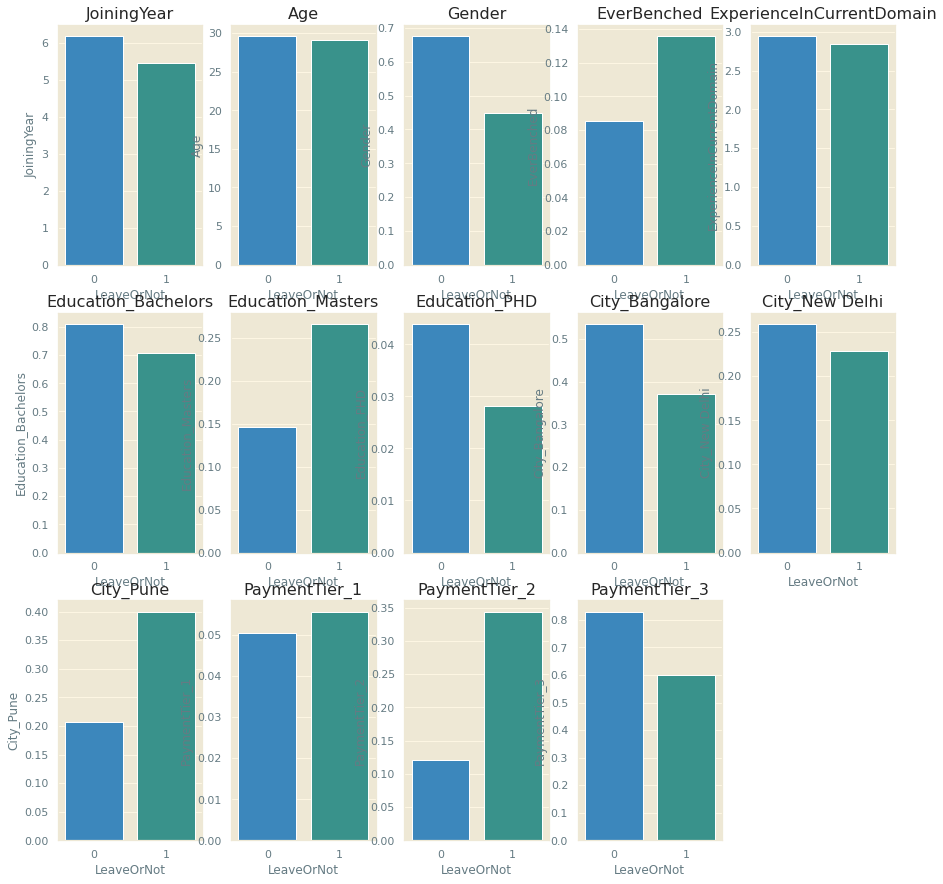

In [17]:
num=0
plt.figure(figsize=(15, 15))
for i in x_col:
    
    num += 1
    plt.subplot(3, 5, num)
    sns.barplot(data=data_LeaveOrNot, y=i, x='LeaveOrNot').set_title(i)
    

plt.show()

****Now these histograms tell us more. Among those who quit (Leave Or Not == 1), a large proportion:**
+ women || `Gender` == 0
+ employees with an average salary level || `PaymentTier_2`
+ those sitting on the bench || `EverBenched`
+ with Education Masters || `Education_Masters`
+ from the city of Pune || `City_Pune`

## Female & Education

In [18]:
data.columns

Index(['JoiningYear', 'Age', 'Gender', 'EverBenched',
       'ExperienceInCurrentDomain', 'LeaveOrNot', 'Education_Bachelors',
       'Education_Masters', 'Education_PHD', 'City_Bangalore',
       'City_New Delhi', 'City_Pune', 'PaymentTier_1', 'PaymentTier_2',
       'PaymentTier_3'],
      dtype='object')

In [19]:
data[data['Education_Bachelors'] == 1]\
    .groupby(['Gender', 'Education_Bachelors'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['count','mean'])

PaymentTier_1           PaymentTier_2            \
                                   count      mean         count      mean   
Gender Education_Bachelors                                                   
0      1                            1435  0.066899          1435  0.283624   
1      1                            2166  0.035549          2166  0.062789   

                           PaymentTier_3            
                                   count      mean  
Gender Education_Bachelors                          
0      1                            1435  0.649477  
1      1                            2166  0.901662

In [20]:
data[data['Education_Masters'] == 1]\
    .groupby(['Gender', 'Education_Masters'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['count','mean'])

PaymentTier_1           PaymentTier_2            \
                                 count      mean         count      mean   
Gender Education_Masters                                                   
0      1                           371  0.075472           371  0.493261   
1      1                           502  0.055777           502  0.342629   

                         PaymentTier_3            
                                 count      mean  
Gender Education_Masters                          
0      1                           371  0.431267  
1      1                           502  0.601594

In [21]:
data[data['Education_PHD'] == 1]\
    .groupby(['Gender', 'Education_PHD'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['count','mean'])

PaymentTier_1           PaymentTier_2            \
                             count      mean         count      mean   
Gender Education_PHD                                                   
0      1                        69  0.101449            69  0.217391   
1      1                       110  0.063636           110  0.045455   

                     PaymentTier_3            
                             count      mean  
Gender Education_PHD                          
0      1                        69  0.681159  
1      1                       110  0.890909

If we look at the distribution of income levels, then in all cases women receive less than men with the same education
and.

**Let's compare wages in different cities.**

## City & Female & Education

### City_Bangalore

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>]],
      dtype=object)

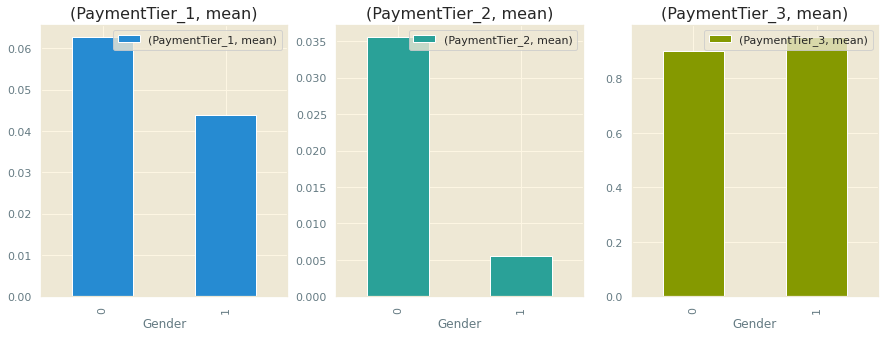

In [22]:
data[(data['City_Bangalore'] == 1) & (data['Education_Bachelors'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 5), layout=(1, 3), stacked=True)

In `Bangalore`, when `Bachelors` are educated, women have a large share of the 1st and 2nd salary levels, therefore men are closer to the 3rd level.

In [23]:
data[(data['City_Bangalore'] == 1) & (data['Education_Bachelors'] == 1)]\
    .groupby(['LeaveOrNot', 'Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean'])

PaymentTier_1 PaymentTier_2 PaymentTier_3
                           mean          mean          mean
LeaveOrNot Gender                                          
0          0           0.073733      0.002304      0.923963
           1           0.047111      0.003556      0.949333
1          0           0.031847      0.127389      0.840764
           1           0.032738      0.011905      0.955357

Those who quit had lower wages than those who work.

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>]],
      dtype=object)

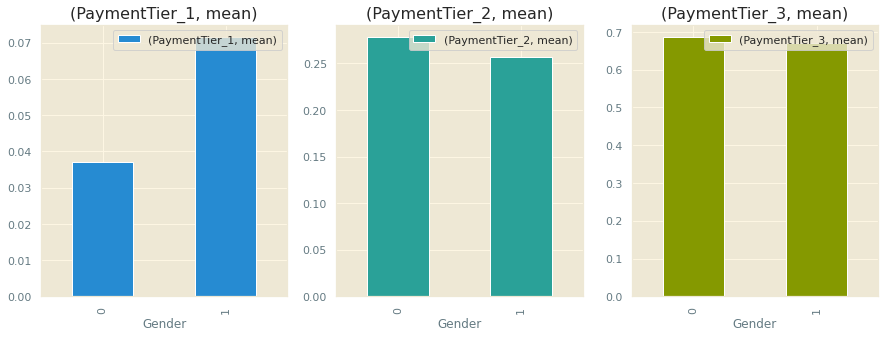

In [24]:
data[(data['City_Bangalore'] == 1) & (data['Education_Masters'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 5), layout=(1, 3), stacked=True)

In `Bangalore`, with `Masters` education, more men receive 1 level of salary, the remaining levels are equal.

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

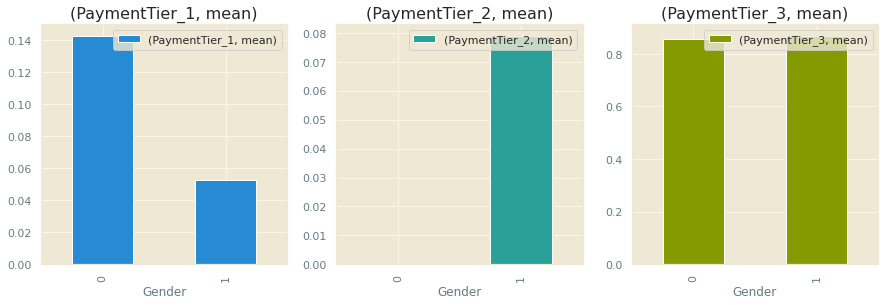

In [25]:
data[(data['City_Bangalore'] == 1) & (data['Education_PHD'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

In `Bangalore`, women receive a lower salary than men for `PHD` education. There are no women with average pay, but there are many with minimal.

### City_New Delhi

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

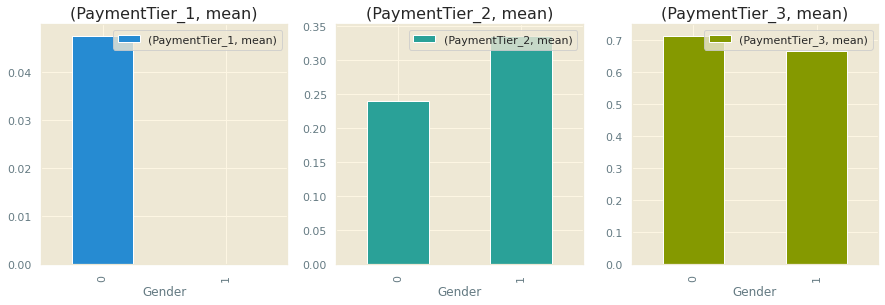

In [26]:
data[(data['City_New Delhi'] == 1) & (data['Education_Bachelors'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

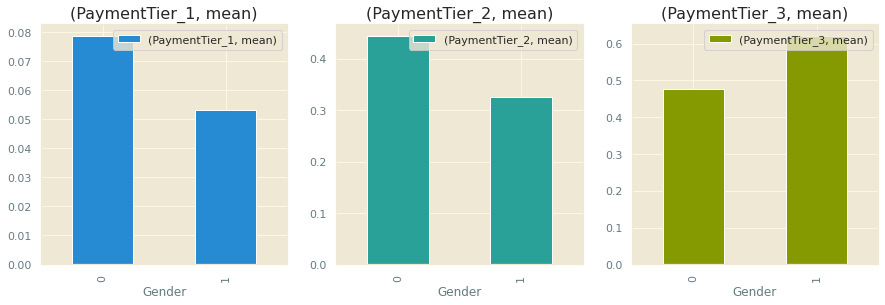

In [27]:
data[(data['City_New Delhi'] == 1) & (data['Education_Masters'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

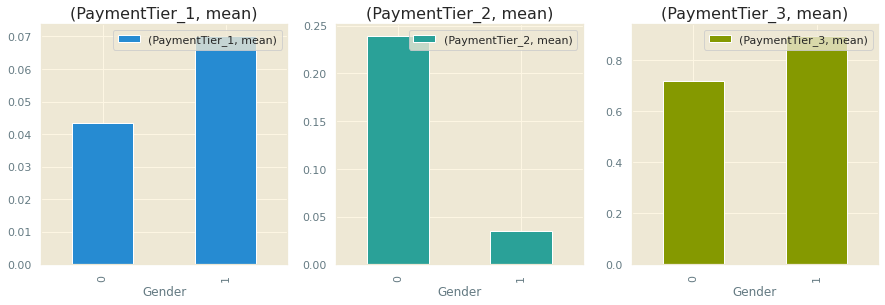

In [28]:
data[(data['City_New Delhi'] == 1) & (data['Education_PHD'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

In `New Delhi`, the minimum wage for women with the same education. Somewhere the same salaries.

### City_Pune

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

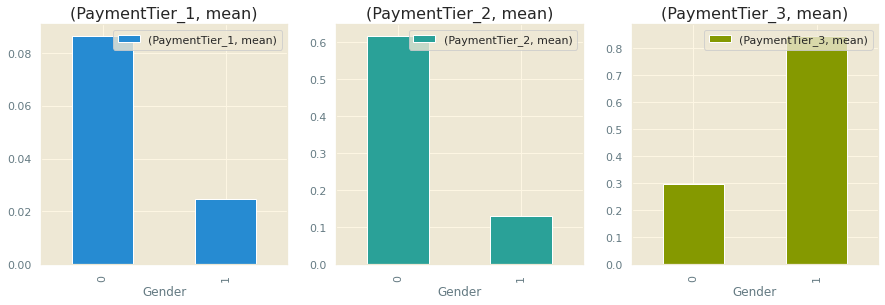

In [29]:
data[(data['City_Pune'] == 1) & (data['Education_Bachelors'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

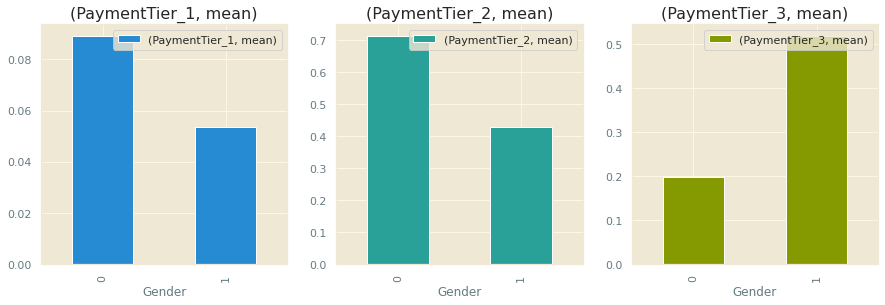

In [30]:
data[(data['City_Pune'] == 1) & (data['Education_Masters'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

array([[<AxesSubplot:title={'center':'(PaymentTier_1, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_2, mean)'}, xlabel='Gender'>,
        <AxesSubplot:title={'center':'(PaymentTier_3, mean)'}, xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>],
       [<AxesSubplot:xlabel='Gender'>, <AxesSubplot:xlabel='Gender'>,
        <AxesSubplot:xlabel='Gender'>]], dtype=object)

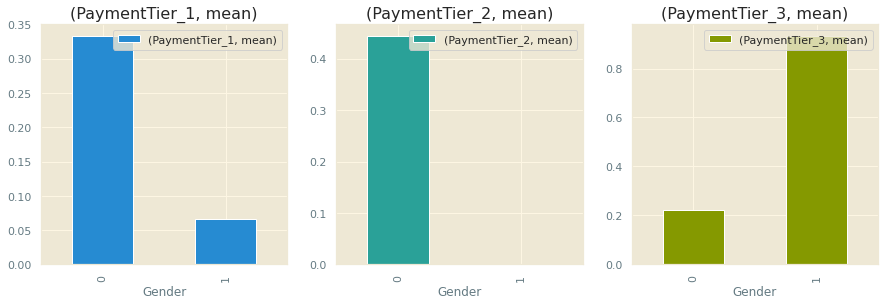

In [31]:
data[(data['City_Pune'] == 1) & (data['Education_PHD'] == 1)]\
    .groupby(['Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['mean']).plot.bar(subplots=True, figsize=(15, 15), layout=(3, 3), stacked=True)

In `Pune`, the salary of men is higher than the salary of women. The skew is clearly visible on the charts. In all other cities, it was clear that men received more than women, but there were also equal levels of wages.

In [32]:
data[(data['City_Pune'] == 1)]\
    .groupby(['LeaveOrNot', 'Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3']]\
    .agg(['count', 'mean'])

PaymentTier_1           PaymentTier_2            \
                          count      mean         count      mean   
LeaveOrNot Gender                                                   
0          0                105  0.076190           105  0.552381   
           1                524  0.034351           524  0.135496   
1          0                491  0.093686           491  0.647658   
           1                148  0.020270           148  0.358108   

                  PaymentTier_3            
                          count      mean  
LeaveOrNot Gender                          
0          0                105  0.371429  
           1                524  0.830153  
1          0                491  0.258656  
           1                148  0.621622

If we compare those who work and those who quit, compare the level of wages, then those who were dismissed received less.

In [33]:
data\
    .groupby(['LeaveOrNot', 'Gender'])\
    [['PaymentTier_1', 'PaymentTier_2', 'PaymentTier_3', 'ExperienceInCurrentDomain', 'JoiningYear']]\
    .agg(['mean'])

PaymentTier_1 PaymentTier_2 PaymentTier_3  \
                           mean          mean          mean   
LeaveOrNot Gender                                             
0          0           0.062563      0.181635      0.755802   
           1           0.044617      0.091174      0.864210   
1          0           0.078054      0.480769      0.441176   
           1           0.027933      0.174581      0.797486   

                  ExperienceInCurrentDomain JoiningYear  
                                       mean        mean  
LeaveOrNot Gender                                        
0          0                       2.933401    6.078708  
           1                       2.943259    6.231814  
1          0                       2.839367    5.719457  
           1                       2.840782    5.160615

`ExperienceInCurrentDomain` and `JoiningYear` are not affected by the fact of dismissal.

What do we have? The fact of dismissal depends on `Gender` and `City`, because there is a high imbalance of `PaymentTier` wages among women in `Pune`. We also saw an imbalance in other cities, but it is much smaller. 491 women quit at Pune, 105 stayed to work, 148 men quit and 524 remained to work. I am sure these data will greatly affect our training.

## JoiningYear & LeaveOrNot

In [34]:
data.groupby(['JoiningYear']).agg("mean").T

JoiningYear,3,4,5,6,7,8,9
Age,29.525886,29.416968,29.552381,29.476312,29.290415,29.008969,29.603175
Gender,0.651226,0.593863,0.660952,0.436620,0.648069,0.621824,0.642857
EverBenched,0.223433,0.077617,0.097143,0.129321,0.065808,0.109118,0.077381
ExperienceInCurrentDomain,2.855586,2.892599,2.853333,2.756722,2.974249,2.983558,3.057540
LeaveOrNot,0.986376,0.268051,0.222857,0.407170,0.247496,0.334828,0.216270
Education_Bachelors,0.716621,0.595668,0.878095,0.819462,0.865522,0.793722,0.875000
Education_Masters,0.204360,0.385379,0.080000,0.138284,0.105866,0.146487,0.097222
Education_PHD,0.079019,0.018953,0.041905,0.042254,0.028612,0.059791,0.027778
City_Bangalore,0.553134,0.333032,0.596190,0.402049,0.553648,0.508221,0.599206
City_New Delhi,0.237057,0.427798,0.180952,0.171575,0.180258,0.222720,0.182540


In the value of `JoiningYear` == 3 (ex 2018), there is a lot of `LeaveOrNot` == 1, as well as a large proportion of `PaymentTier_3` - almost 1.

In [35]:
data[(data['JoiningYear'] == 3) & data['LeaveOrNot'] == 1].groupby('JoiningYear').agg(['mean']).T

,JoiningYear,3
Age,mean,29.535912
Gender,mean,0.649171
EverBenched,mean,0.218232
ExperienceInCurrentDomain,mean,2.853591
LeaveOrNot,mean,1.000000
Education_Bachelors,mean,0.715470
Education_Masters,mean,0.204420
Education_PHD,mean,0.080110
City_Bangalore,mean,0.552486
City_New Delhi,mean,0.237569


In [36]:
data.groupby('PaymentTier_3').agg(['mean']).T

,PaymentTier_3,0,1
JoiningYear,mean,5.457364,6.096506
Age,mean,29.268734,29.434708
Gender,mean,0.366064,0.673826
EverBenched,mean,0.095607,0.105097
ExperienceInCurrentDomain,mean,2.871662,2.916953
LeaveOrNot,mean,0.550388,0.275200
Education_Bachelors,mean,0.616710,0.826174
Education_Masters,mean,0.354005,0.132302
Education_PHD,mean,0.029285,0.041523
City_Bangalore,mean,0.152455,0.587342


Also interesting observation, all those who quit received high wages, were hired in the last year in 2018 - `JoiningYear` == 3. 71% had `Bachelors`, 20% had `Education_Masters` and 8% had `Education_PHD`. And almost all of them received a high salary `PaymentTier_3`. Perhaps a new department was opened, and then it was reduced. Or it's just an anomaly in the data, but they will greatly affect our learning.

In [37]:
data.corr()['LeaveOrNot']

JoiningYear                 -0.181705
Age                         -0.051126
Gender                      -0.220701
EverBenched                  0.078438
ExperienceInCurrentDomain   -0.030504
LeaveOrNot                   1.000000
Education_Bachelors         -0.118176
Education_Masters            0.145801
Education_PHD               -0.038938
City_Bangalore              -0.154996
City_New Delhi              -0.033341
City_Pune                    0.206264
PaymentTier_1                0.011065
PaymentTier_2                0.266426
PaymentTier_3               -0.250702
Name: LeaveOrNot, dtype: float64

There are no strong correlations.

In [38]:
data

,JoiningYear,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
0,4,34,1,0,0,0,1,0,0,1,0,0,0,0,1
1,8,28,0,0,3,1,1,0,0,0,0,1,1,0,0
2,7,38,0,0,2,0,1,0,0,0,1,0,0,0,1
3,5,27,1,0,5,1,0,1,0,1,0,0,0,0,1
4,4,24,1,1,2,1,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648,8,26,0,0,4,0,1,0,0,1,0,0,0,0,1
4649,8,37,1,0,2,1,0,1,0,0,0,1,0,1,0
4650,3,27,1,0,5,1,0,1,0,0,1,0,0,0,1
4651,9,30,1,1,2,0,1,0,0,1,0,0,0,0,1


# Split and Scaler

In [39]:
X = data.drop(['LeaveOrNot'], axis=1)
y = data['LeaveOrNot']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [40]:
numerical = ['JoiningYear', 'Age', 'ExperienceInCurrentDomain']

In [41]:
scaler = StandardScaler()

x_train_scaler = scaler.fit_transform(x_train[numerical])
x_test_scaler = scaler.transform(x_test[numerical])

x_train[numerical] = x_train_scaler
x_test[numerical] = x_test_scaler

In [42]:
x_train

,JoiningYear,Age,Gender,EverBenched,ExperienceInCurrentDomain,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,PaymentTier_1,PaymentTier_2,PaymentTier_3
899,-1.028973,-0.481529,1,0,1.333438,1,0,0,0,0,1,0,0,1
537,0.587181,-0.688817,1,1,0.691266,1,0,0,1,0,0,0,0,1
1132,-1.028973,-1.103392,1,0,-0.593077,1,0,0,1,0,0,0,0,1
1542,1.125899,-0.896104,1,0,0.049095,1,0,0,1,0,0,0,0,1
1915,0.587181,-0.481529,1,0,1.333438,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648,1.125899,-0.688817,0,0,0.691266,1,0,0,1,0,0,0,0,1
3545,0.587181,0.762198,1,0,1.333438,1,0,0,1,0,0,0,0,1
1847,-0.490255,-0.688817,1,1,0.691266,1,0,0,1,0,0,0,0,1
2148,0.587181,-0.688817,1,0,0.691266,1,0,0,1,0,0,0,0,1


# Train the model

Define the functions

In [43]:
def quality_report(actual, prediction):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}\nRoc_auc: {:.3f}".format(
        accuracy_score(actual, prediction),
        precision_score(actual, prediction),
        recall_score(actual, prediction),
        f1_score(actual, prediction),
        roc_auc_score(actual, prediction)))

In [44]:
def plot_features(clf):
    feature_importances = clf.feature_importances_
    pd.DataFrame({'features': x_train.columns,
                                           'feature_importances': feature_importances})\
    .sort_values('feature_importances', ascending=False).plot.barh(x ='features', figsize=(10, 7))

In [45]:
def data_features(clf):
    feature_importances = clf.feature_importances_
    return pd.DataFrame({'features': x_train.columns,
                                           'feature_importances': feature_importances})\
    .sort_values('feature_importances', ascending=False)

In [46]:
def con_matrix(actual, prediction):
    tn, fp, fn, tp = confusion_matrix(actual, prediction).ravel()
    print('True Positive', tp, ' - employees who were correctly predicted to be fired')
    print('False Negative', fn, ' - employees who were supposed to work but quit')
    print('True Negative', tn, ' - employees who were supposed to work and are working')
    print('False Positive', fp, ' - employees who were incorrectly predicted to be fired')

## RandomForestClassifier

In [47]:
rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1, random_state=42)

rnd_clf.fit(x_train, y_train)

predict_rnd = rnd_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_rnd)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_rnd)



Test quality: 

Accuracy: 0.825
Precision: 0.944
Recall: 0.523
f1_score: 0.673
Roc_auc: 0.753

The confusion matrix : 

True Positive 251  - employees who were correctly predicted to be fired
False Negative 229  - employees who were supposed to work but quit
True Negative 901  - employees who were supposed to work and are working
False Positive 15  - employees who were incorrectly predicted to be fired


In [48]:
data_features(rnd_clf)

,features,feature_importances
0,JoiningYear,0.375895
2,Gender,0.118962
12,PaymentTier_2,0.106252
10,City_Pune,0.093901
13,PaymentTier_3,0.092852
6,Education_Masters,0.070565
5,Education_Bachelors,0.044195
1,Age,0.022915
9,City_New Delhi,0.021652
8,City_Bangalore,0.019970


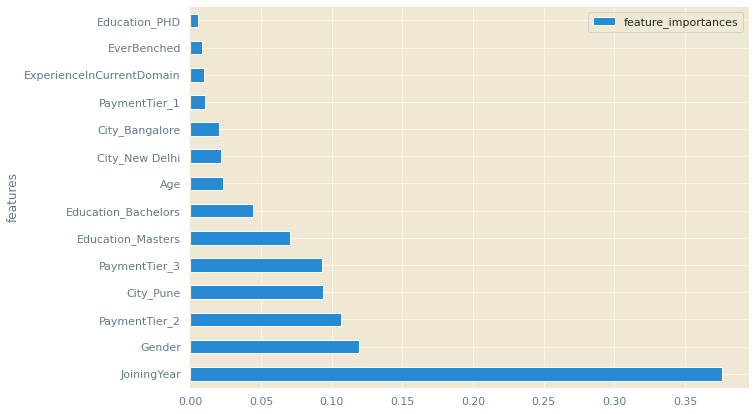

In [49]:
plot_features(rnd_clf)

## ExtraTreesClassifier

In [50]:
ex_clf = ExtraTreesClassifier(n_estimators=200, max_leaf_nodes=14, n_jobs=-1,  random_state=42)

ex_clf.fit(x_train, y_train)

predict_ex = ex_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_ex)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_ex)


Test quality: 

Accuracy: 0.787
Precision: 0.917
Recall: 0.417
f1_score: 0.573
Roc_auc: 0.699

The confusion matrix : 

True Positive 200  - employees who were correctly predicted to be fired
False Negative 280  - employees who were supposed to work but quit
True Negative 898  - employees who were supposed to work and are working
False Positive 18  - employees who were incorrectly predicted to be fired


In [51]:
data_features(ex_clf)

,features,feature_importances
0,JoiningYear,0.178471
12,PaymentTier_2,0.159686
2,Gender,0.156734
10,City_Pune,0.118667
6,Education_Masters,0.099470
13,PaymentTier_3,0.088248
5,Education_Bachelors,0.078112
9,City_New Delhi,0.047125
8,City_Bangalore,0.035638
3,EverBenched,0.011203


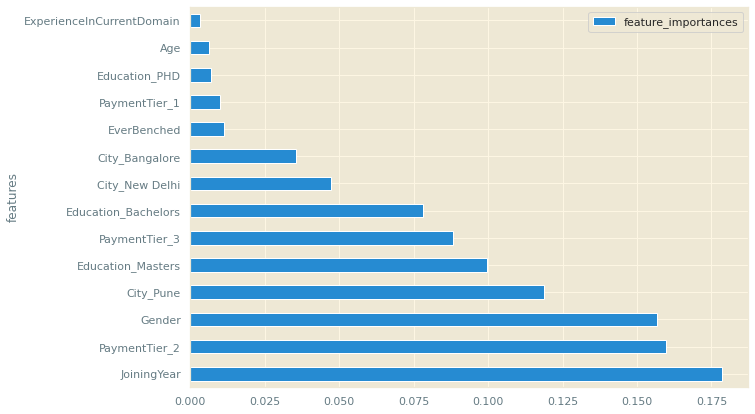

In [52]:
plot_features(ex_clf)

## GradientBoostingClassifier

In [53]:
gdc_clf = GradientBoostingClassifier(n_estimators=100, max_features='auto', max_depth = 4, random_state = 42) 

gdc_clf.fit(x_train, y_train)

predict_gbc = gdc_clf.predict(x_test)

print('\nTest quality: \n')
quality_report(y_test, predict_gbc)
print('\nThe confusion matrix : \n')
con_matrix(y_test, predict_gbc)


Test quality: 

Accuracy: 0.853
Precision: 0.892
Recall: 0.652
f1_score: 0.753
Roc_auc: 0.805

The confusion matrix : 

True Positive 313  - employees who were correctly predicted to be fired
False Negative 167  - employees who were supposed to work but quit
True Negative 878  - employees who were supposed to work and are working
False Positive 38  - employees who were incorrectly predicted to be fired


In [54]:
data_features(gdc_clf)

,features,feature_importances
0,JoiningYear,0.402709
10,City_Pune,0.099860
6,Education_Masters,0.091003
12,PaymentTier_2,0.088491
13,PaymentTier_3,0.087934
5,Education_Bachelors,0.049377
2,Gender,0.047875
1,Age,0.043879
4,ExperienceInCurrentDomain,0.022549
8,City_Bangalore,0.021684


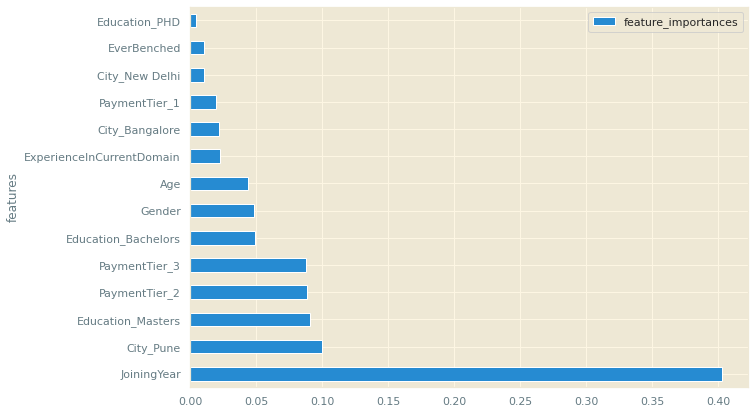

In [55]:
plot_features(gdc_clf)

What does our result say? If a company spends huge resources on training and adapting new employees, but there are not many such employees in the labor market, the company needs to know for sure that a person will leave, then our algorithm copes with this task perfectly and if it determines that a person will leave, then he will definitely leave. If it is important for us to find all those who can leave, then our model will cope poorly with this task, because the model has a low `recall`.

# ROC Curves and AUC

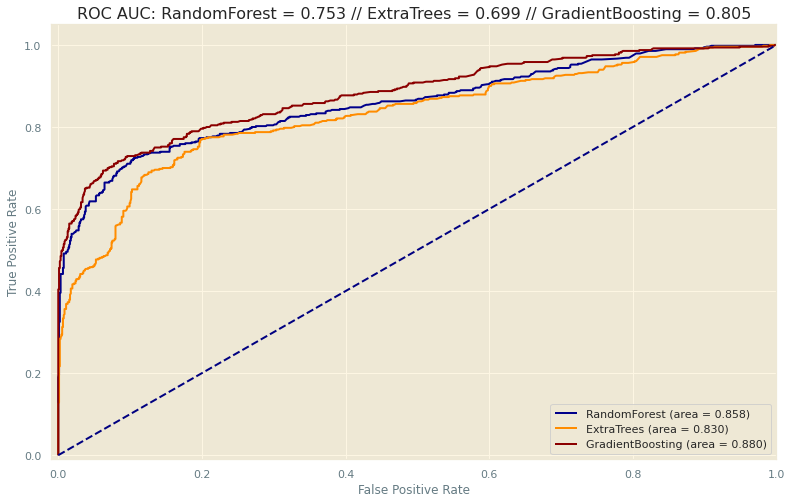

In [56]:
y_predicted_prob_rnd = rnd_clf.predict_proba(x_test)
y_predicted_prob_ex = ex_clf.predict_proba(x_test)
y_predicted_prob_gdc = gdc_clf.predict_proba(x_test)

fpr_rnd, tpr_rnd, thresholds_rnd = roc_curve(y_test, y_predicted_prob_rnd[:,1])
fpr_ex, tpr_ex, thresholds_ex = roc_curve(y_test, y_predicted_prob_ex[:,1])
fpr_gdc, tpr_gdc, thresholds_gdc = roc_curve(y_test, y_predicted_prob_gdc[:,1])

plt.figure(figsize=(13,8))
plt.plot(fpr_rnd, tpr_rnd, color='darkblue', label='RandomForest (area = %0.3f)' % auc(fpr_rnd, tpr_rnd))
plt.plot(fpr_ex, tpr_ex, color='darkorange', label='ExtraTrees (area = %0.3f)' % auc(fpr_ex, tpr_ex))
plt.plot(fpr_gdc, tpr_gdc, color='darkred', label='GradientBoosting (area = %0.3f)' % auc(fpr_gdc, tpr_gdc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC AUC: RandomForest = {:.3f} // ExtraTrees = {:.3f} // GradientBoosting = {:.3f}'\
          .format(roc_auc_score(y_test, predict_rnd),
                  roc_auc_score(y_test, predict_ex),
                  roc_auc_score(y_test, predict_gbc)))
plt.legend(loc="lower right", title_fontsize='xx-large')

plt.show()